In the following task, a classification algorithm for classifying fingerprint images into 5 different group using only traditional image processing methods is performed.
First dataset is download from the following [link](https://academictorrents.com/details/d7e67e86f0f936773f217dbbb9c149c4d98748c6). Before that a torrent client is activated using an application called Transmision, and dataset is fetched using peer network sharing. Then, dataset is uploaded to google drive and here I mount it to use and extract it. dataset which was in a zip format file is copied into the colab space and then unizped it.

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
!cp drive/MyDrive/NIST.zip ./

In [ ]:
!unzip NIST.zip

In [ ]:
import os
import cv2

The following code is genereated to extract the class of a image file by reading second line of the txt files. classes are porvided in the txt file with the same name of the original images in the second line.

In [ ]:
# Function to extract class from the text file
def extract_class(txt_file_path):
    with open(txt_file_path, 'r') as file:
        lines = file.readlines()
        class_line = lines[1].strip()
        class_label = class_line.split(': ')[1]
        return class_label

In the following, dataset is distributed in 8 different folders. I read the images as gray scale images and their associated class labels one by one using opencv and store them in a seprate lists for further usage.
There are 2000 images in general. (there are 4000, but 2000 of them are same as the other but with different resolution, I just consider the files that started with `f` to avoid overfitting and misevaluation of the proposed algorithm.)


In [ ]:
data_folder = './NISTSpecialDatabase4GrayScaleImagesofFIGS/sd04/png_txt/'

# List to store the images and their associated classes
images = []
classes = []

# Iterate over the folders
for folder_number in range(8):
    folder_path = os.path.join(data_folder, f'figs_{folder_number}')
    file_names = os.listdir(folder_path)

    # Iterate over the files in the folder
    for file_name in file_names:
        if file_name.endswith('.png') and file_name.startswith('f'):
            image_path = os.path.join(folder_path, file_name)
            txt_file_name = file_name.replace('.png', '.txt')
            txt_file_path = os.path.join(folder_path, txt_file_name)

            # Read the image using OpenCV
            image = cv2.imread(image_path, cv2.IMREAD_GRAYSCALE)

            # Extract the associated class from the text file
            class_label = extract_class(txt_file_path)

            # Append the image and class to the lists
            images.append(image)
            classes.append(class_label)

# Print the number of images and their associated classes
print(f"Number of images: {len(images)}")
print(f"Number of classes: {len(classes)}")

Number of images: 2000
Number of classes: 2000


In [ ]:
from collections import Counter

counter = Counter(classes)

unique_elements = list(counter.keys())
repetitions = list(counter.values())

print(unique_elements)
print(repetitions)

['T', 'L', 'R', 'W', 'A']
[400, 400, 400, 400, 400]


In the following section, preprocessing steps are performed on the images which will be elucidated in follows:
- `binarize_image`: takes a grayscale image as input and converts it to a binary image. It uses a thresholding technique to assign pixel values based on a given threshold. Pixels with intensities above the threshold are set to 255 (white), while pixels below the threshold are set to 0 (black).
- `perform_opening`: performs an opening operation on a binary image. Opening consists of an erosion followed by a dilation. It is typically used to remove noise and small objects from the foreground. kernel_size parameter specifies the size of the structuring element used for the operation. The function uses a rectangular structuring element.
- `perform_closing`: This function performs a closing operation on a binary image. Closing consists of a dilation followed by an erosion. It is commonly used to fill small holes and gaps in the foreground. Other parameters is same as the opening operation.
In the following cell, an image randomly is selected from the dataset and I made a deep copy from it. then different stages of preprocessing is visualised to show the enhancing and alternations that are being performed in each section. It includes binarizing the image, performing the opening operation, and closing perform on the output of the opening operation.

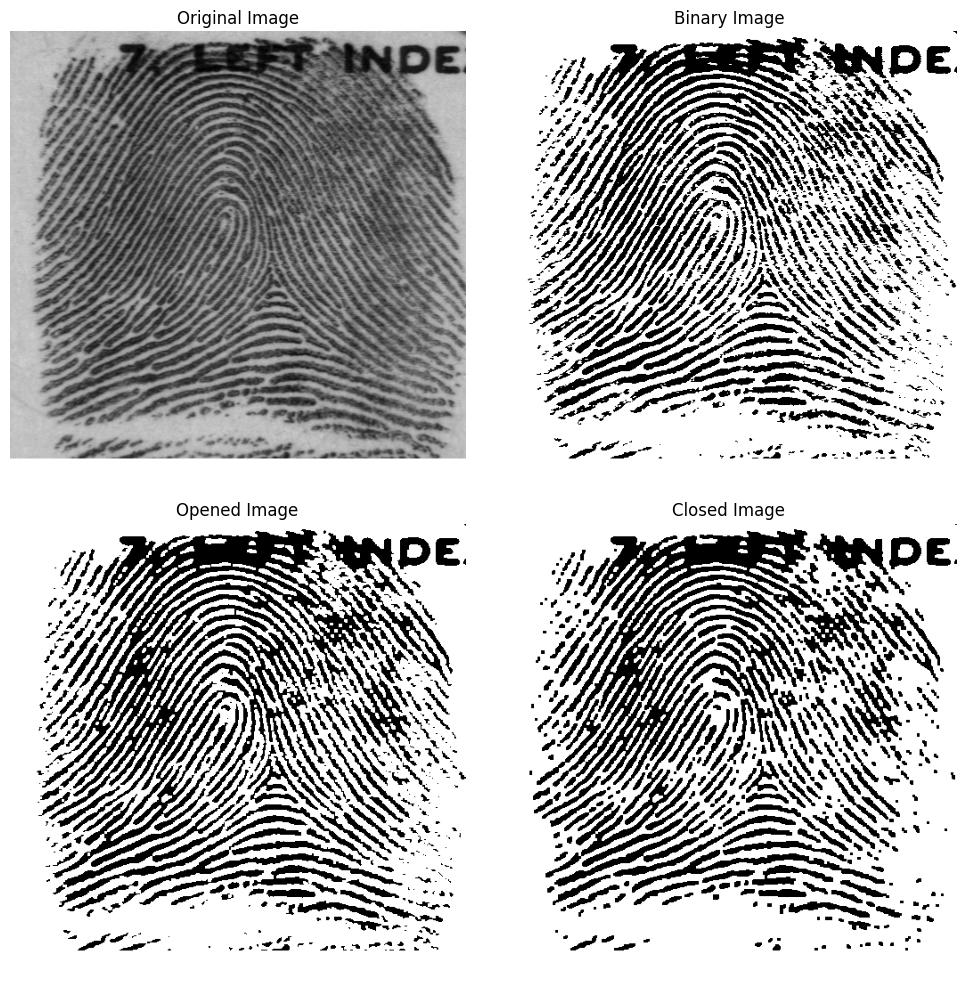

In [ ]:
import random
import matplotlib.pyplot as plt
import numpy as np
import copy

# Function to convert grayscale image to binary image
def binarize_image(image, threshold=90):
    _, binary_image = cv2.threshold(image, threshold, 255, cv2.THRESH_BINARY)
    return binary_image

# Function to perform opening
def perform_opening(binary_image, kernel_size):
    kernel = cv2.getStructuringElement(cv2.MORPH_RECT, (kernel_size, kernel_size))
    opened_image = cv2.morphologyEx(binary_image, cv2.MORPH_OPEN, kernel)
    return opened_image

# Function to perform closing
def perform_closing(binary_image, kernel_size):
    kernel = cv2.getStructuringElement(cv2.MORPH_RECT, (kernel_size, kernel_size))
    closed_image = cv2.morphologyEx(binary_image, cv2.MORPH_CLOSE, kernel)
    return closed_image

# Randomly select an image index
random_index = random.randint(0, len(images) - 1)
image = copy.deepcopy(images[random_index])

# Convert image to binary
binary_image = binarize_image(image)

# Perform opening on the binary image
opened_image = perform_opening(binary_image, kernel_size=3)

# Perform closing on the output of the opening operation
closed_image = perform_closing(opened_image, kernel_size=3)

# Visualization
fig, axes = plt.subplots(2, 2, figsize=(10, 10))
axes[0, 0].imshow(image, cmap='gray')
axes[0, 0].set_title('Original Image')

axes[0, 1].imshow(binary_image, cmap='gray')
axes[0, 1].set_title('Binary Image')

axes[1, 0].imshow(opened_image, cmap='gray')
axes[1, 0].set_title('Opened Image')

axes[1, 1].imshow(closed_image, cmap='gray')
axes[1, 1].set_title('Closed Image')

for ax in axes.flatten():
    ax.axis('off')

plt.tight_layout()
plt.show()

In the following, using functions defined in the previous section, the preprocessing steps is performed on the whole dataset and stored in a seperated list for further usage.

In [ ]:
closed_images = []

# Iterate over each image
for image in images:
    # Performing preprocessing steps
    binary_image = binarize_image(image)
    opened_image = perform_opening(binary_image, kernel_size=3)
    closed_image = perform_closing(binary_image, kernel_size=3)

    # Append processed images to the lists
    closed_images.append(closed_image)

#### HOG
The Histogram of Oriented Gradients (HOG) is a feature descriptor that is widely used in computer vision and image processing tasks. It represents the distribution of gradient orientations in an image to capture local shape and texture information. It works by dividing the image into small, overlapping cells. For each cell, it calculates the gradient orientations and magnitudes of the pixel intensity values. The gradient orientation represents the direction of the change in intensity, while the magnitude represents the strength of the change. Once the gradient orientations and magnitudes are computed for each pixel in the cell, the HOG algorithm constructs a histogram of gradient orientations. The histogram divides the range of gradient orientations into a fixed number of bins, and each bin represents a specific range of orientations. The histogram bins accumulate the magnitudes of the gradients based on their corresponding orientations within the cell. To capture more information about the local structure, the HOG algorithm also incorporates a block normalization step. It groups adjacent cells into blocks and normalizes the histogram values within each block. This normalization helps to reduce the influence of illumination variations and enhances the robustness of the HOG features. The final HOG feature vector is obtained by concatenating the normalized histograms of all the cells within the image. The resulting feature vector provides a compact representation of the image's local gradient distribution, capturing important information about edges, corners, and other texture patterns.
I used HOG implemented in `skimage` package in the following cell to visualize the orientation of different blocks in a random data in the dataset to demonstrate the feature extracted using this method.

I also implemented this method from scratch in the extra section for completeness.

- `orientations`: specifies the number of orientation bins in the histogram. It determines the granularity of the gradient orientations captured.
- `pixels_per_cell`: sets the size of the cell over which the gradient orientations will be computed.
- `cells_per_block`: determines the number of cells per block. The HOG features are computed within each block of cells, and this parameter specifies the size of the block.


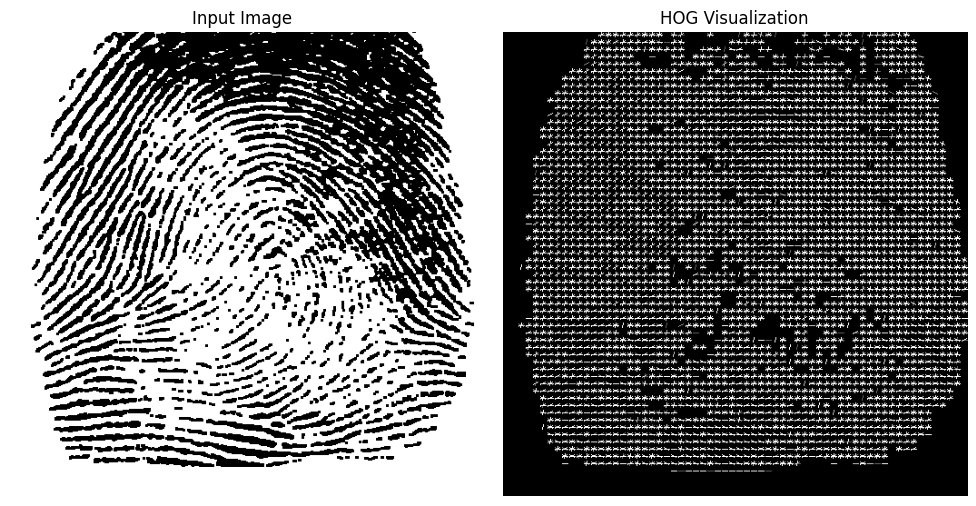

In [ ]:
from skimage.feature import hog
from skimage import exposure

# Load the fingerprint image
random_index = np.random.randint(0, len(images))
image = np.copy(closed_images[random_index])

hog_features, hog_image = hog(image, orientations=9, pixels_per_cell=(8, 8), cells_per_block=(2, 2), visualize=True)

# Rescale histogram for better display
hog_image_rescaled = exposure.rescale_intensity(hog_image, in_range=(0, 10))

fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(10, 5))

ax1.imshow(image, cmap='gray')
ax1.set_title('Input Image')
ax1.axis('off')

ax2.imshow(hog_image_rescaled, cmap='gray')
ax2.set_title('HOG Visualization')
ax2.axis('off')

plt.tight_layout()
plt.show()

The following is the proposed method that can classify fingerprints based on the extracted features described earlier into five classes based on comparing cosine similarity of the features.

A function is generated to calculates the general HOG features for each class in a dataset. It takes a list of images and their corresponding class labels (classes). It also takes an optional parameter num_samples which determines the number of samples to be used for each class.
1. It first identifies the unique classes in the classes list.
2. Then, for each class, it selects a subset of num_samples images from the images list that belong to that class.
3. For each selected image, it computes the HOG features using the calculate_hog() function.
4. The HOG features are stored in a NumPy array, and the average HOG features are calculated across all the selected images for each class.
5. Finally, it creates a dictionary called general_hog where the keys are the class labels and the values are the average HOG features.

for predicting class label for the images in the dataset also another function is generated which perform as follows:
1. It calculates the HOG features for the input image using the calculate_hog() function.
2. It initializes an empty dictionary called similarities to store the similarity scores between the HOG features of the input image and the general HOG features of each class.
3. For each class label and its corresponding general HOG features in general_hog, it computes the cosine similarity between the two feature vectors.
4. The similarity scores are stored in the similarities dictionary, where the keys are the class labels and the values are the similarity scores.
5. Finally, it determines the predicted class label by selecting the class with the highest similarity score.

In [ ]:
import numpy as np
import skimage.io
from skimage.feature import hog
from sklearn.metrics.pairwise import cosine_similarity

def calculate_hog(image):
    _, hog_features = hog(image, orientations=9, pixels_per_cell=(8, 8), cells_per_block=(2, 2), visualize=True)
    return hog_features.flatten()

def calculate_general_hog(images, classes, num_samples=50):
    unique_classes = np.unique(classes)
    general_hog = {}

    for class_label in unique_classes:
        class_images = [image for image, label in zip(images, classes) if label == class_label]
        class_samples = class_images[:num_samples]
        hog_features = np.array([calculate_hog(image) for image in class_samples])
        average_hog = np.mean(hog_features, axis=0)
        general_hog[class_label] = average_hog

    return general_hog

def assign_class(image, general_hog):
    image_hog = calculate_hog(image)
    similarities = {}

    for class_label, hog_features in general_hog.items():
        similarity = cosine_similarity(hog_features.reshape(1, -1), image_hog.reshape(1, -1))
        similarities[class_label] = similarity[0][0]

    predicted_class = max(similarities, key=similarities.get)
    return predicted_class

# Calculate the general HOG for each class
general_hog = calculate_general_hog(closed_images, classes)

# Assign class labels to each image
predicted_labels = [assign_class(image, general_hog) for image in images]

In [ ]:
from sklearn.metrics import accuracy_score, f1_score, precision_score, recall_score, confusion_matrix

accuracy = accuracy_score(classes, predicted_labels)
f1 = f1_score(classes, predicted_labels, average='weighted')
precision = precision_score(classes, predicted_labels, average='weighted')
recall = recall_score(classes, predicted_labels, average='weighted')
confusion = confusion_matrix(classes, predicted_labels)

print("Accuracy:", accuracy)
print("F1 Score:", f1)
print("Precision:", precision)
print("Recall:", recall)
print("Confusion Matrix:")
print(confusion)

Accuracy: 0.533
F1 Score: 0.49769839412321437
Precision: 0.5669514098534045
Recall: 0.533
Confusion Matrix:
[[ 44  56  93 192  15]
 [  7 157  29 111  96]
 [  2   5 320  53  20]
 [ 15  32 113 225  15]
 [  0  14  48  18 320]]


## Extras
In the following, I put the codes that I have used to perform exploration into the dataset and get insight about the data and experiment different features that I was going to use to perform the classification in the first place. Alos, I implemented the HOG method from scratch and perform it on the data for completeness.


### HOG From Scratch and Testing on the Dataset
In the following, first, compute_gradient function calculates the gradient of an input image. It applies the Sobel operator to compute the gradients in the x and y directions. The function returns the magnitude and angle of the gradients.

The compute_histogram function computes a histogram of the gradient magnitudes in each cell. It takes in the cell magnitudes, cell angles, and the number of bins for the histogram as inputs. It initializes an array to store the histogram and calculates the angle unit based on the number of bins. Then, it iterates over the cell magnitudes and angles, and for each pixel, it finds the corresponding bin based on the angle and increments the histogram value for that bin.

The normalize_histogram function normalizes the histogram by adding a small epsilon value, taking the square root of each histogram bin, and dividing by the Euclidean norm of the histogram.

The compute_hog function takes an input image and optional parameters for cell size, block size, and the number of bins. It calculates the image's height and width and then computes the gradient magnitudes and angles using the compute_gradient function. It creates an array to store the histograms for each cell in the image. It iterates over each cell, extracts the corresponding gradient magnitudes and angles, and computes the histogram using the compute_histogram function. The resulting histograms are stored in the cell_gradient_vectors array. The function initializes an array to store the HOG representation of the image and iterates over each block in cell_gradient_vectors. It flattens the block vector, normalizes it using the normalize_histogram function, and assigns it to the corresponding region in the hog_image array. Finally, the function returns the hog_image, which represents the Histogram of Oriented Gradients for the input image.

In [ ]:
import numpy as np
import cv2

def compute_gradient(image):
    gx = cv2.Sobel(image, cv2.CV_32F, 1, 0, ksize=1)
    gy = cv2.Sobel(image, cv2.CV_32F, 0, 1, ksize=1)
    magnitude, angle = cv2.cartToPolar(gx, gy, angleInDegrees=True)
    return magnitude, angle

def compute_histogram(cell_magnitude, cell_angle, bins):
    histogram = np.zeros(bins)
    angle_unit = 360.0 / bins

    for i in range(cell_magnitude.shape[0]):
        for j in range(cell_magnitude.shape[1]):
            magnitude = cell_magnitude[i, j]
            angle = cell_angle[i, j]
            k = int(angle / angle_unit)
            histogram[k] += magnitude

    return histogram

def normalize_histogram(block_histogram):
    epsilon = 1e-5
    block_histogram += epsilon
    block_histogram = np.sqrt(block_histogram)
    block_histogram /= np.linalg.norm(block_histogram)

    return block_histogram

def compute_hog(image, cell_size=3, block_size=2, bins=9):
    height, width = image.shape
    gradient_magnitude, gradient_angle = compute_gradient(image)

    cell_gradient_vectors = np.zeros((int(height / cell_size), int(width / cell_size), bins))
    for i in range(cell_gradient_vectors.shape[0]):
        for j in range(cell_gradient_vectors.shape[1]):
            cell_magnitude = gradient_magnitude[i * cell_size:(i + 1) * cell_size,
                                               j * cell_size:(j + 1) * cell_size]
            cell_angle = gradient_angle[i * cell_size:(i + 1) * cell_size,
                                         j * cell_size:(j + 1) * cell_size]
            cell_gradient_vectors[i, j] = compute_histogram(cell_magnitude, cell_angle, bins)

    hog_image = np.zeros((height, width))

    for i in range(cell_gradient_vectors.shape[0] - block_size + 1):
        for j in range(cell_gradient_vectors.shape[1] - block_size + 1):
            block_vector = cell_gradient_vectors[i:i + block_size, j:j + block_size, :].flatten()
            block_vector = normalize_histogram(block_vector)
            hog_image[i * cell_size:(i + block_size) * cell_size,
                      j * cell_size:(j + block_size) * cell_size] = block_vector.reshape(block_size * cell_size, block_size * cell_size)


    return hog_image

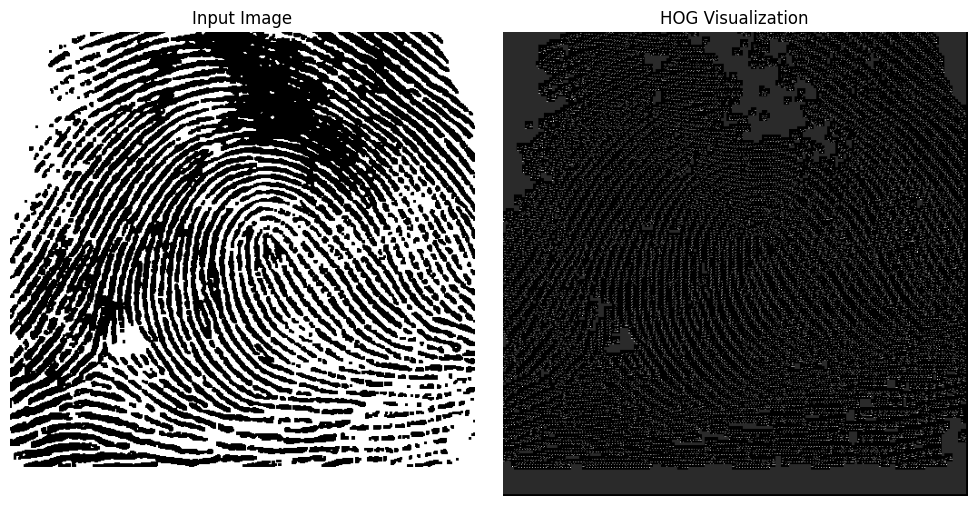

In [ ]:
# Load the fingerprint image
random_index = np.random.randint(0, len(images))
image = np.copy(closed_images[random_index])

hog_image = compute_hog(image)

# Rescale histogram for better display
hog_image_rescaled = exposure.rescale_intensity(hog_image, in_range=(0, 10))

fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(10, 5))

ax1.imshow(image, cmap='gray')
ax1.set_title('Input Image')
ax1.axis('off')

ax2.imshow(hog_image, cmap='gray')
ax2.set_title('HOG Visualization')
ax2.axis('off')

plt.tight_layout()
plt.show()

### Exploration through the dataset for finding good features for classifiction

In [ ]:
import cv2
import numpy as np
from skimage.feature import peak_local_max
from skimage.morphology import skeletonize
from skimage.transform import rotate
import matplotlib.pyplot as plt

In the following, The calculate_orientation function calculates the ridge orientation of an input image. It uses the Sobel operator to compute the gradients in the x and y directions. The function then calculates the orientation of the ridges using the np.arctan2 function and converts it to degrees. The orientation values are returned.

The estimate_frequency function estimates the ridge frequency of an input image. It computes the gradients in the x and y directions using the Sobel operator. The gradient magnitudes are then calculated by taking the square root of the sum of squared gradients. Gaussian smoothing is applied to the gradient magnitudes. Finally, the ridge frequency is estimated by dividing the block size by the smoothed gradient magnitude.

The analyze_curvature function analyzes the ridge curvature of an input orientation map. It initializes an array to store the curvature values. It iterates over the orientation map and for each pixel, it extracts a local neighborhood of size block_size. The standard deviation of the local orientation values is calculated and stored in the curvature array.

The extract_minutiae function extracts minutiae points from a binary image. It firstly, thin the binary image and then, Minutiae points are then detected using the peak_local_max function from the skimage.feature module. The min_distance and threshold_abs parameters control the minimum distance between points and the minimum threshold for peak detection. The resulting minutiae points are returned.

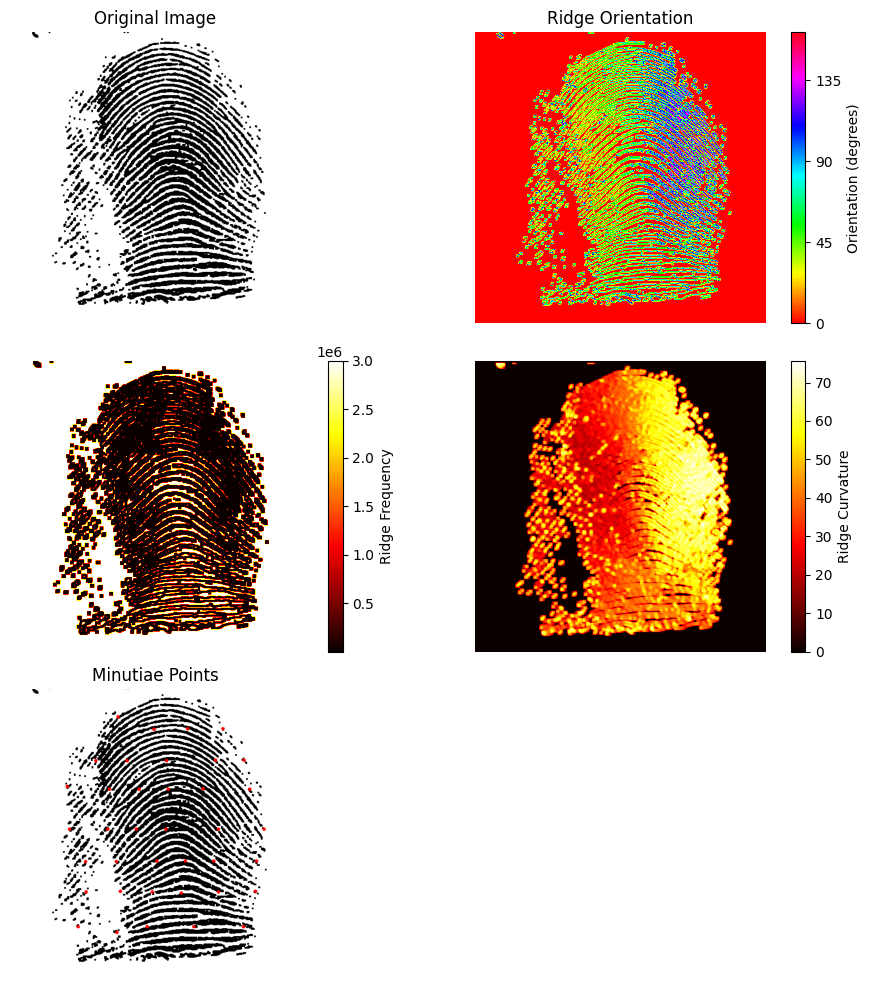

In [ ]:
import numpy as np
import cv2
import matplotlib.pyplot as plt
from skimage.feature import peak_local_max

def calculate_orientation(image, block_size=16, sigma=3):
    # Calculate the gradient in the x-direction
    dx = cv2.Sobel(image, cv2.CV_64F, 1, 0, ksize=3)

    # Calculate the gradient in the y-direction
    dy = cv2.Sobel(image, cv2.CV_64F, 0, 1, ksize=3)

    # Calculate the orientation of ridges
    orientation = np.arctan2(dy, dx)
    orientation = np.rad2deg(orientation) % 180

    return orientation

def estimate_frequency(image, block_size=3, sigma=3):
    # Calculate the gradient in the x-direction
    dx = cv2.Sobel(image, cv2.CV_64F, 1, 0, ksize=3)

    # Calculate the gradient in the y-direction
    dy = cv2.Sobel(image, cv2.CV_64F, 0, 1, ksize=3)

    # Calculate the gradient magnitude
    gradient_magnitude = np.sqrt(dx**2 + dy**2)

    # Apply Gaussian smoothing to the gradient magnitude
    smoothed_gradient = cv2.GaussianBlur(gradient_magnitude, (block_size, block_size), sigmaX=sigma, sigmaY=sigma)

    # Estimate the ridge frequency
    ridge_frequency = block_size / (smoothed_gradient + 1e-6)

    return ridge_frequency

def analyze_curvature(orientation, block_size=3):
    # Calculate the curvature of ridges
    curvature = np.zeros_like(orientation)
    for i in range(block_size, orientation.shape[0] - block_size):
        for j in range(block_size, orientation.shape[1] - block_size):
            local_orientation = orientation[i - block_size:i + block_size, j - block_size:j + block_size]
            curvature[i, j] = np.std(local_orientation)

    return curvature

def extract_minutiae(image, threshold=0.5, min_distance=50):
    # Thin the binary image
    thinned_image = cv2.ximgproc.thinning(image)

    # Detect minutiae points
    minutiae_points = peak_local_max(thinned_image, min_distance=min_distance, threshold_abs=threshold, labels=thinned_image)

    return minutiae_points

# Load the fingerprint image
random_index = np.random.randint(0, len(images))
image = np.copy(closed_images[random_index])

orientation = calculate_orientation(image)
ridge_frequency = estimate_frequency(image)
curvature = analyze_curvature(orientation)

edges = cv2.Canny(image, 100, 200)
minutiae_map = extract_minutiae(edges)

# Visualize the extracted features
fig, axes = plt.subplots(3, 2, figsize=(10, 10))

# Show the original image
axes[0, 0].imshow(image, cmap='gray')
axes[0, 0].set_title('Original Image')

cax = axes[0, 1].imshow(orientation, cmap='hsv')
axes[0, 1].set_title('Ridge Orientation')

# Add a colorbar
cbar = fig.colorbar(cax, ax=axes[0, 1], ticks=[0, 45, 90, 135, 180])
cbar.set_label('Orientation (degrees)')

# Add a colorbar for ridge frequency and set the ticks and label
cbar_freq = fig.colorbar(axes[1, 0].imshow(ridge_frequency, cmap='hot'), ax=axes[1, 0])
cbar_freq.set_label('Ridge Frequency')

# Add a colorbar for ridge curvature and set the ticks and label
cbar_curv = fig.colorbar(axes[1, 1].imshow(curvature, cmap='hot'), ax=axes[1, 1])
cbar_curv.set_label('Ridge Curvature')

# Plot the minutiae points on the original image
image_vis = np.copy(image)
image_vis = cv2.cvtColor(image_vis, cv2.COLOR_GRAY2RGB)
for point in minutiae_map:
    i, j = point[0], point[1]
    image_vis = cv2.circle(image_vis, (j, i), 3, (255, 0, 0), -1)

axes[2, 0].imshow(image_vis)
axes[2, 0].set_title('Minutiae Points')

for ax in axes.ravel():
    ax.axis('off')

plt.tight_layout()
plt.show()

In the following, I calculate muliple statistics factors on the values of the previous cell to find some thereshold and criteria to distinguish images into different classes based on these feature. But, as it can be seen from the result, the majority of these factors are near to each other and therefore can not be used in the classification task. That why I shift to the HOG feature extractor since it produce more meaningful and valuable information about the magnitude and the orientation of the gradients in a small local pieces in the image and can be used as a factor to classify the fingerprint images.

In [ ]:
from scipy import stats

# Dictionary to store the statistics for each class
class_statistics = {}

# Iterate over the images and labels
for image, label in zip(closed_images[:100], classes[:100]):
    # Calculate ridge orientation of the edges
    orientation = calculate_orientation(image)

    # Estimate ridge frequency
    ridge_frequency = estimate_frequency(image)

    # Analyze ridge curvature
    curvature = analyze_curvature(orientation)

    # Extract minutiae points
    edges = cv2.Canny(image, 100, 200)
    minutiae_map = extract_minutiae(edges)

    # Calculate the statistics for orientation, frequency, curvature, and number of minutiae
    orientation_mean = np.mean(orientation)
    orientation_max = np.max(orientation)
    orientation_average = np.average(orientation)
    orientation_mode = stats.mode(orientation.flatten())[0][0]
    orientation_min = np.min(orientation)

    frequency_mean = np.mean(ridge_frequency)
    frequency_max = np.max(ridge_frequency)
    frequency_average = np.average(ridge_frequency)
    frequency_mode = stats.mode(ridge_frequency.flatten())[0][0]
    frequency_min = np.min(ridge_frequency)

    curvature_mean = np.mean(curvature)
    curvature_max = np.max(curvature)
    curvature_average = np.average(curvature)
    curvature_mode = stats.mode(curvature.flatten())[0][0]
    curvature_min = np.min(curvature)

    minutiae_count = len(minutiae_map)

    # Check if the class label exists in the dictionary
    if label not in class_statistics:
        class_statistics[label] = {
            'orientation_mean': [],
            'orientation_max': [],
            'orientation_average': [],
            'orientation_mode': [],
            'orientation_min': [],
            'frequency_mean': [],
            'frequency_max': [],
            'frequency_average': [],
            'frequency_mode': [],
            'frequency_min': [],
            'curvature_mean': [],
            'curvature_max': [],
            'curvature_average': [],
            'curvature_mode': [],
            'curvature_min': [],
            'minutiae_count': [],
        }

    # Add the statistics to the corresponding class
    class_statistics[label]['orientation_mean'].append(orientation_mean)
    class_statistics[label]['orientation_max'].append(orientation_max)
    class_statistics[label]['orientation_average'].append(orientation_average)
    class_statistics[label]['orientation_mode'].append(orientation_mode)
    class_statistics[label]['orientation_min'].append(orientation_min)

    class_statistics[label]['frequency_mean'].append(frequency_mean)
    class_statistics[label]['frequency_max'].append(frequency_max)
    class_statistics[label]['frequency_average'].append(frequency_average)
    class_statistics[label]['frequency_mode'].append(frequency_mode)
    class_statistics[label]['frequency_min'].append(frequency_min)

    class_statistics[label]['curvature_mean'].append(curvature_mean)
    class_statistics[label]['curvature_max'].append(curvature_max)
    class_statistics[label]['curvature_average'].append(curvature_average)
    class_statistics[label]['curvature_mode'].append(curvature_mode)
    class_statistics[label]['curvature_min'].append(curvature_min)

    class_statistics[label]['minutiae_count'].append(minutiae_count)

# Print the statistics for each class
for label, stats_dict in class_statistics.items():
    print(f"Class: {label}")
    print(f"Orientation - Mean: {np.mean(stats_dict['orientation_mean'])}")
    print(f"Orientation - Max: {np.max(stats_dict['orientation_max'])}")
    print(f"Orientation - Average: {np.average(stats_dict['orientation_average'])}")
    print(f"Orientation - Mode: {stats.mode(stats_dict['orientation_mode'])[0][0]}")
    print(f"Orientation - Min: {np.min(stats_dict['orientation_min'])}")

    print(f"Frequency - Mean: {np.mean(stats_dict['frequency_mean'])}")
    print(f"Frequency - Max: {np.max(stats_dict['frequency_max'])}")
    print(f"Frequency - Average: {np.average(stats_dict['frequency_average'])}")
    print(f"Frequency - Mode: {stats.mode(stats_dict['frequency_mode'])[0][0]}")
    print(f"Frequency - Min: {np.min(stats_dict['frequency_min'])}")

    print(f"Curvature - Mean: {np.mean(stats_dict['curvature_mean'])}")
    print(f"Curvature - Max: {np.max(stats_dict['curvature_max'])}")
    print(f"Curvature - Average: {np.average(stats_dict['curvature_average'])}")
    print(f"Curvature - Mode: {stats.mode(stats_dict['curvature_mode'])[0][0]}")
    print(f"Curvature - Min: {np.min(stats_dict['curvature_min'])}")

    print(f"Minutiae Count: {np.mean(stats_dict['minutiae_count'])}")
    print("------------")

<ipython-input-116-b8c8ff4357cb>:28: FutureWarning: Unlike other reduction functions (e.g. `skew`, `kurtosis`), the default behavior of `mode` typically preserves the axis it acts along. In SciPy 1.11.0, this behavior will change: the default value of `keepdims` will become False, the `axis` over which the statistic is taken will be eliminated, and the value None will no longer be accepted. Set `keepdims` to True or False to avoid this warning.
  orientation_mode = stats.mode(orientation.flatten())[0][0]
<ipython-input-116-b8c8ff4357cb>:34: FutureWarning: Unlike other reduction functions (e.g. `skew`, `kurtosis`), the default behavior of `mode` typically preserves the axis it acts along. In SciPy 1.11.0, this behavior will change: the default value of `keepdims` will become False, the `axis` over which the statistic is taken will be eliminated, and the value None will no longer be accepted. Set `keepdims` to True or False to avoid this warning.
  frequency_mode = stats.mode(ridge_frequ

Class: T
Orientation - Mean: 13.570163207025065
Orientation - Max: 161.565051177078
Orientation - Average: 13.570163207025065
Orientation - Mode: 0.0
Orientation - Min: 0.0
Frequency - Mean: 2080953.3534529656
Frequency - Max: 3000000.0
Frequency - Average: 2080953.3534529656
Frequency - Mode: 3000000.0
Frequency - Min: 0.0029411764677047293
Curvature - Mean: 17.368430127164675
Curvature - Max: 77.13320805542193
Curvature - Average: 17.368430127164675
Curvature - Mode: 0.0
Curvature - Min: 0.0
Minutiae Count: 33.26086956521739
------------
Class: L
Orientation - Mean: 16.15627468708193
Orientation - Max: 161.565051177078
Orientation - Average: 16.15627468708193
Orientation - Mode: 0.0
Orientation - Min: 0.0
Frequency - Mean: 1897989.9592355394
Frequency - Max: 3000000.0
Frequency - Average: 1897989.9592355394
Frequency - Mode: 3000000.0
Frequency - Min: 0.0029411764677047293
Curvature - Mean: 20.23191877691854
Curvature - Max: 77.13320805542193
Curvature - Average: 20.23191877691854
Cu

<ipython-input-116-b8c8ff4357cb>:93: FutureWarning: Unlike other reduction functions (e.g. `skew`, `kurtosis`), the default behavior of `mode` typically preserves the axis it acts along. In SciPy 1.11.0, this behavior will change: the default value of `keepdims` will become False, the `axis` over which the statistic is taken will be eliminated, and the value None will no longer be accepted. Set `keepdims` to True or False to avoid this warning.
  print(f"Orientation - Mode: {stats.mode(stats_dict['orientation_mode'])[0][0]}")
<ipython-input-116-b8c8ff4357cb>:99: FutureWarning: Unlike other reduction functions (e.g. `skew`, `kurtosis`), the default behavior of `mode` typically preserves the axis it acts along. In SciPy 1.11.0, this behavior will change: the default value of `keepdims` will become False, the `axis` over which the statistic is taken will be eliminated, and the value None will no longer be accepted. Set `keepdims` to True or False to avoid this warning.
  print(f"Frequency